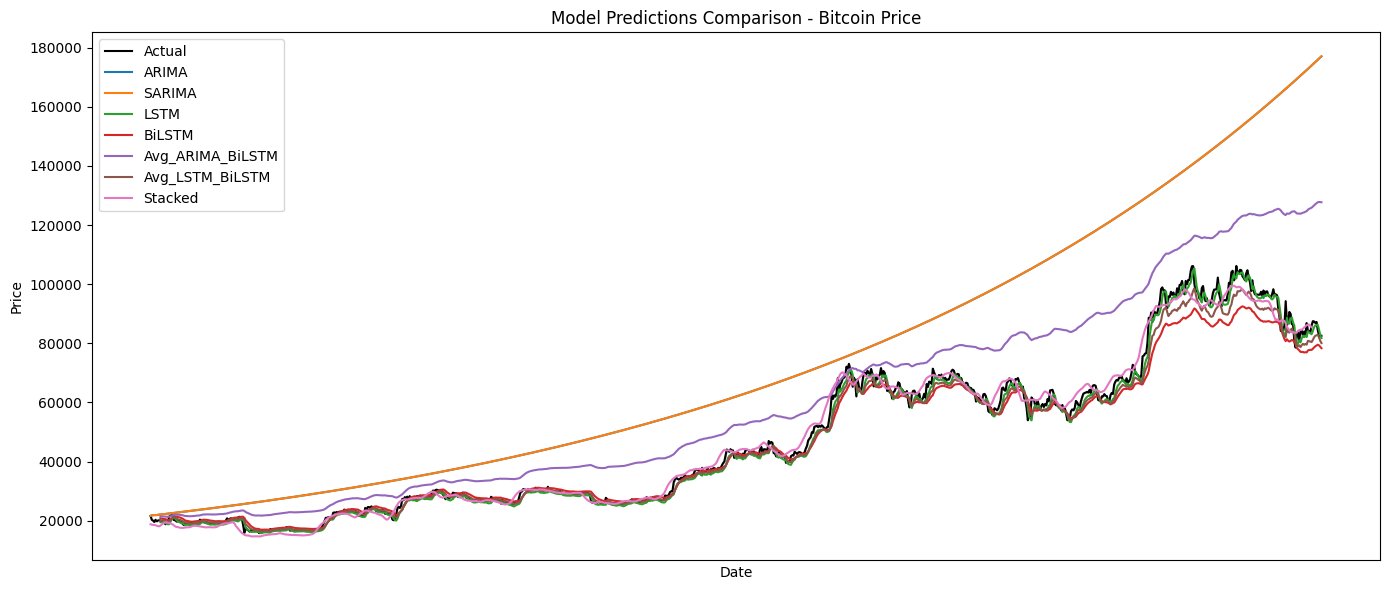


Full Model Comparison Table:
              Model           MAE           MSE          RMSE  R2 Score
0             ARIMA  26156.795635  1.097078e+09  33122.170159 -0.614036
1            SARIMA  26156.795635  1.097078e+09  33122.170159 -0.614036
2              LSTM   1440.875686  3.845439e+06   1960.979038  0.994336
3            BiLSTM   2827.654963  1.961541e+07   4428.928529  0.971108
4  Avg_ARIMA_BiLSTM  12169.239989  2.330367e+08  15265.540205  0.656757
5   Avg_LSTM_BiLSTM   1910.784123  8.462976e+06   2909.119534  0.987535
6           Stacked   1891.383638  6.777981e+06   2603.455552  0.989937


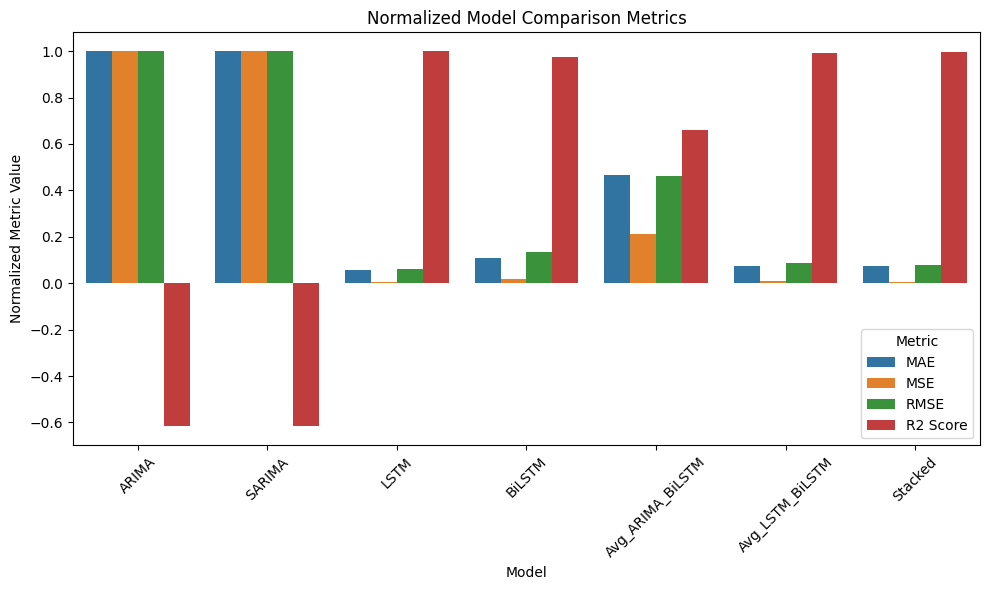

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Paths
outputs_dir = '../outputs/metrics'
figures_dir = '../outputs/figures'

# Load all predictions
files = {
    'ARIMA': 'ARIMA_predictions.csv',
    'SARIMA': 'SARIMA_predictions.csv',
    'LSTM': 'LSTM_predictions.csv',
    'BiLSTM': 'BiLSTM_predictions.csv',
    'Avg_ARIMA_BiLSTM': 'ARIMA_BiLSTM_Avg_predictions.csv',
    'Avg_LSTM_BiLSTM': 'LSTM_BiLSTM_Avg_predictions.csv',
    'Stacked': 'Stacked_Ensemble_predictions.csv'
}

model_dfs = {}

for name, file in files.items():
    df = pd.read_csv(os.path.join(outputs_dir, file))
    df.columns = ['Date', 'Actual', 'Predicted'] if 'Actual_Price' not in df.columns else ['Date', 'Actual_Price', 'Predicted_Price']
    df.rename(columns={
        'Actual_Price': 'Actual',
        'Predicted_Price': 'Predicted'
    }, inplace=True)
    df['Model'] = name
    model_dfs[name] = df

# Combine all models into one DataFrame
combined_df = pd.concat(model_dfs.values(), axis=0)

# Plot predictions from each model
plt.figure(figsize=(14, 6))
sns.lineplot(data=combined_df, x='Date', y='Actual', label='Actual', color='black')

for model_name in model_dfs.keys():
    sns.lineplot(data=model_dfs[model_name], x='Date', y='Predicted', label=model_name)

plt.xticks([])
plt.title('Model Predictions Comparison - Bitcoin Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'All_Model_Comparison.png'))
plt.show()


# Evaluate all models and store metrics
results = []

for model_name, df in model_dfs.items():
    y_true = df['Actual']
    y_pred = df['Predicted']
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    results.append({
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2 Score': r2
    })
    
results_df = pd.DataFrame(results)

# Print the original table with all metrics for the 7 models
print("\nFull Model Comparison Table:")
print(results_df)

# Convert results into DataFrame
results_df = pd.DataFrame(results)

# Normalize the metrics by dividing each by its maximum value
metrics = ['MAE', 'MSE', 'RMSE', 'R2 Score']
for metric in metrics:
    max_value = results_df[metric].max()
    results_df[metric] = results_df[metric] / max_value

# Prepare data for visualization
normalized_df = results_df.melt(id_vars='Model', value_vars=[metric for metric in metrics])
normalized_df.columns = ['Model', 'Metric', 'Normalized Value']

# Barplot of normalized metrics
plt.figure(figsize=(10, 6))
sns.barplot(data=normalized_df, x='Model', y='Normalized Value', hue='Metric')
plt.title('Normalized Model Comparison Metrics')
plt.ylabel('Normalized Metric Value')
plt.xticks(rotation=45)
plt.tight_layout()

# Save and show plot
plt.savefig(os.path.join(figures_dir, 'Model_Comparison_Metrics.png'))
plt.show()

# Save normalized results to CSV
normalized_results_df = results_df[['Model'] + [metric for metric in metrics]]
normalized_results_df.to_csv(os.path.join(outputs_dir, 'Model_Comparison_Metrics.csv'), index=False)

results_df.to_csv(os.path.join(outputs_dir, 'Full_Model_Comparison_Metrics.csv'), index=False)
